In [20]:

from PIL import Image, ImageOps, ImageChops
import numpy as np

def mnist_style_preprocess_pil(pil_img):
    img = pil_img.convert('L')
    arr = np.array(img)
    if arr.mean() > 127:
        img = ImageOps.invert(img)
        arr = np.array(img)

    img = img.point(lambda p: 255 if p > 50 else 0)

    bbox = img.getbbox()
    if bbox:
        img = img.crop(bbox)
    else:
        return np.zeros((28,28), dtype=np.float32)

    max_side = max(img.size)
    square = Image.new('L', (max_side, max_side), color=0)
    square.paste(img, ((max_side - img.size[0])//2, (max_side - img.size[1])//2))

    img20 = square.resize((20,20), Image.Resampling.LANCZOS)

    img28 = Image.new('L', (28,28), color=0)
    img28.paste(img20, (4,4))

    arr28 = np.array(img28).astype(np.float32)
    ys, xs = np.where(arr28 > 0)
    if len(xs) > 0:
        cx = xs.mean()
        cy = ys.mean()
        shiftx = int(round(14 - cx))
        shifty = int(round(14 - cy))
        img28 = ImageChops.offset(Image.fromarray(arr28.astype('uint8')), shiftx, shifty)
        arr28 = np.array(img28).astype(np.float32)

    arr28 = arr28 / 255.0
    return arr28


In [21]:
import numpy as np
from tensorflow.keras.datasets import mnist
from PIL import Image, ImageFilter
from scipy.ndimage import binary_dilation
import random
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

def make_canvas_style(img_arr):
    img = Image.fromarray(img_arr).resize((140,140), Image.Resampling.NEAREST)
    img = img.point(lambda p: 255 if p > 50 else 0)
    arr = np.array(img)
    mask = arr > 0
    mask = binary_dilation(mask, structure=np.ones((3,3)))  
    arr = (mask.astype(np.uint8) * 255)
    pil = Image.fromarray(arr).filter(ImageFilter.GaussianBlur(radius=1))
    small = pil.resize((28,28), Image.Resampling.LANCZOS)
    small = ImageOps.invert(small)
    return np.array(small)

aug_images = []
aug_labels = []

N = 30000  
indices = np.random.choice(len(x_train), N, replace=True)
for idx in indices:
    base = x_train[idx]
    label = y_train[idx]
    thick = make_canvas_style(base)
    aug_images.append(thick.astype(np.float32) / 255.0)
    aug_labels.append(label)

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)

X_orig = x_train.astype(np.float32)/255.0
X_orig = X_orig[:30000]  
Y_orig = y_train[:30000]

X_train_aug = np.concatenate([X_orig.reshape(-1,28,28), aug_images], axis=0)
Y_train_aug = np.concatenate([Y_orig, aug_labels], axis=0)

perm = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[perm]
Y_train_aug = Y_train_aug[perm]

X_train_aug = X_train_aug[..., np.newaxis]
x_test = x_test.astype(np.float32)/255.0
x_test = x_test[..., np.newaxis]

print("Augmented training shape:", X_train_aug.shape, Y_train_aug.shape)


Augmented training shape: (60000, 28, 28, 1) (60000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

def get_improved_model():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_improved_model()
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('mnist_canvas_robust.h5', save_best_only=True)
]

history = model.fit(X_train_aug, Y_train_aug, epochs=10, batch_size=128, validation_split=0.1, callbacks=callbacks, verbose=1)

model.load_weights('mnist_canvas_robust.h5')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



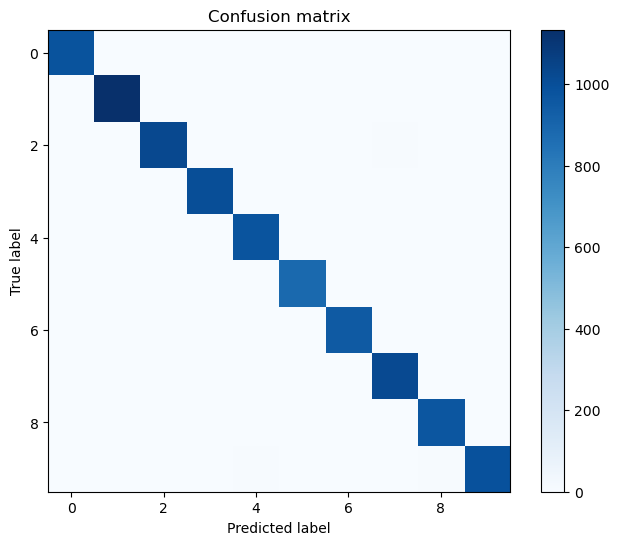

In [23]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
import numpy as np
import cv2

canvas_size = 280  
canvas = np.ones((canvas_size, canvas_size), dtype='uint8') * 255
drawing = False
brush_size = 10  

def on_mouse(event, x, y, flags, param):
    global drawing, canvas
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        cv2.circle(canvas, (x, y), brush_size, (0, 0, 0), -1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

cv2.namedWindow('Draw Digit (press S to save, Q to quit)')
cv2.setMouseCallback('Draw Digit (press S to save, Q to quit)', on_mouse)

while True:
    cv2.imshow('Draw Digit (press S to save, Q to quit)', canvas)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('s'):
        img_resized = cv2.resize(canvas, (28, 28), interpolation=cv2.INTER_AREA)
        img_inverted = cv2.bitwise_not(img_resized)
        cv2.imwrite('digit.png', img_inverted)
        print("✅ Image saved as 'digit.png'")
        break

    elif key == ord('q'):
        print("❌ Exited without saving.")
        break

cv2.destroyAllWindows()


✅ Image saved as 'digit.png'


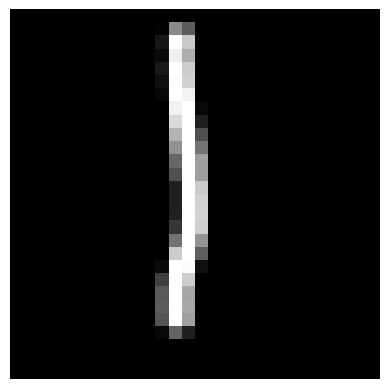

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Predicted: 1 conf: 0.9999999


In [26]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("digit.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

from PIL import Image
import numpy as np
model = tf.keras.models.load_model('mnist_canvas_robust.h5')

pil = Image.open('digit.png')  # your canvas saved file
arr28 = mnist_style_preprocess_pil(pil)   # returns 28x28 float array
inp = arr28.reshape(1,28,28,1)
preds = model.predict(inp)
print("Predicted:", np.argmax(preds), "conf:", preds.max())
